# MountainCar-v0

## Components

### Libraries

In [1]:
!pip install keras-rl2
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

Requirement already up-to-date: colabgymrender in /usr/local/lib/python3.7/dist-packages (1.0.9)


In [2]:
from gym.envs.classic_control.mountain_car import MountainCarEnv
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, MaxBoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger
from rl.agents import DQNAgent
from rl.callbacks import Callback
from colabgymrender.recorder import Recorder
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from collections import defaultdict
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import json
import gym
import random
from time import time
from itertools import product
import glob
import os

print(f'tensorflow version = {tf.__version__}')
print(tf.config.list_physical_devices('GPU'))
print()

np.random.seed(0)
random.seed(0)

# FIXME
display = Display(visible=0, size=(400, 300))
display.start()

tensorflow version = 2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



### Environment

In [3]:
class MountainCarWithNoiseEnv(MountainCarEnv):
    def __init__(self, goal_velocity=0, sigma=0):
        super().__init__(goal_velocity)
        self.sigma = sigma

    def step(self, action):
        state, reward, done, info = super().step(action)
        
        if self.sigma > 0:
            state[0] += np.random.normal(0, self.sigma)
            state[1] += np.random.normal(0, self.sigma)
        
        return state, reward, done, info

### Neural Network

In [4]:
def get_model(env):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(env.action_space.n))
    
    return model

### Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

MAIN_DIR = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def get_experiment(enable_double_dqn, policy_name, sigma):
    agent_name = 'DDQN' if enable_double_dqn else 'DQN'
    return agent_name + ' ' + policy_name + f' sigma={sigma}'

def get_results_file_name(enable_double_dqn, policy_name, sigma):
    return MAIN_DIR + get_experiment(enable_double_dqn, policy_name, sigma) + '.json'

def get_video_file_name(enable_double_dqn, policy_name, sigma):
    return MAIN_DIR + get_experiment(enable_double_dqn, policy_name, sigma) + '.mp4'

### Agent

In [7]:
def run_experiment(enable_double_dqn, policy_name, policy, test_policy, sigma):
    t0 = time()

    env = MountainCarWithNoiseEnv(sigma=sigma)
    
    env.seed(0)
    np.random.seed(0)
    
    model = get_model(env)
    
    agent = DQNAgent(model=model,
                     nb_actions=env.action_space.n, 
                     memory=SequentialMemory(limit=50000, window_length=1), 
                     nb_steps_warmup=50, 
                     target_model_update=1e-2, 
                     policy=policy,
                     test_policy=test_policy,
                     enable_double_dqn=enable_double_dqn)
        
    agent.compile(keras.optimizers.Adam(lr=1e-3), metrics=['mae'])

    results_file_name = get_results_file_name(enable_double_dqn, policy_name, sigma)
    agent.fit(env, nb_steps=150000, nb_max_episode_steps=200,
              callbacks=[FileLogger(results_file_name)])

    env = Recorder(env, MAIN_DIR)
    agent.test(env, nb_episodes=5, nb_max_episode_steps=200)

    try:
        env.play()
    except:
        print('Video playback failed!')

    list_of_files = glob.glob(MAIN_DIR + '*.mp4')
    latest_file = max(list_of_files, key=os.path.getctime)
    video_file_name = get_video_file_name(enable_double_dqn, policy_name, sigma)
    os.rename(latest_file, video_file_name)

    env.close()

    print(f'Total time: {(time() - t0)/60:.1f} min')

### Plots

In [8]:
def exponential_smoothing(x, alpha):
    y = np.zeros_like(x)
    
    y[0] = x[0]
    
    for i in range(1, len(x)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    
    return y

def plot_results(enable_double_dqns, policy_names, sigmas):
    if type(enable_double_dqns) != list: enable_double_dqns = [enable_double_dqns]
    if type(policy_names) != list: policy_names = [policy_names]
    if type(sigmas) != list: sigmas = [sigmas]

    plt.figure(figsize=(8, 6))
    plt.title('Mean reward per episode (smooth)')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    for enable_double_dqn, policy_name, sigma in product(enable_double_dqns, policy_names, sigmas):
        results_file_name = get_results_file_name(enable_double_dqn, policy_name, sigma)     
        with open(results_file_name, 'r') as f:
            results = json.load(f)
        episodes = results['episode']
        rewards = results['episode_reward']
        rewards = exponential_smoothing(rewards, 0.01)
        experiment = get_experiment(enable_double_dqn, policy_name, sigma)
        plt.plot(episodes, rewards, label=experiment)
    plt.legend()
    plt.show()
    print()

    plt.figure(figsize=(8, 6))
    plt.title('Mean Q per episode')
    plt.xlabel('Episodes')
    plt.ylabel('Q')
    for enable_double_dqn, policy_name, sigma in product(enable_double_dqns, policy_names, sigmas):
        results_file_name = get_results_file_name(enable_double_dqn, policy_name, sigma)     
        with open(results_file_name, 'r') as f:
            results = json.load(f)
        episodes = results['episode']
        rewards = results['mean_q']
        experiment = get_experiment(enable_double_dqn, policy_name, sigma)
        plt.plot(episodes, rewards, label=experiment)
    plt.legend()
    plt.show()
    print()

## Experiments

### DQN EpsGreedy 

In [9]:
run_experiment(False, 'EpsGreedy', EpsGreedyQPolicy(eps=0.1), EpsGreedyQPolicy(eps=0.05), 0)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.583 - mae: 20.348 - mean_q: -30.115

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 7.063 - mae: 36.211 - mean_q: -53.645

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -198.800 [-200.000, -158.000] - loss: 8.293 - mae: 39.980 - mean_q: -59.256

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -1.0000
51 episodes - episode_reward: -196.216 [-200.000, -134.000] - loss: 7.960 - mae: 40.043 - mean_q: -59.335

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 91s 9ms/step

Total time: 22.7 min


In [10]:
run_experiment(False, 'EpsGreedy', EpsGreedyQPolicy(eps=0.1), EpsGreedyQPolicy(eps=0.05), 0.002)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -199.200 [-200.000, -160.000] - loss: 2.398 - mae: 19.955 - mean_q: -29.472

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -1.0000
51 episodes - episode_reward: -195.882 [-200.000, -132.000] - loss: 6.882 - mae: 36.115 - mean_q: -53.398

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -1.0000
57 episodes - episode_reward: -174.737 [-200.000, -126.000] - loss: 6.755 - mae: 37.310 - mean_q: -54.961

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -1.0000
63 episodes - episode_reward: -159.746 [-200.000, -92.000] - loss: 5.086 - mae: 34.888 - mean_q: -51.228

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 93s 9ms/step 

Total time: 23.0 min


In [11]:
run_experiment(False, 'EpsGreedy', EpsGreedyQPolicy(eps=0.1), EpsGreedyQPolicy(eps=0.05), 0.004)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -196.680 [-200.000, -103.000] - loss: 2.472 - mae: 20.194 - mean_q: -29.875

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -1.0000
53 episodes - episode_reward: -188.491 [-200.000, -123.000] - loss: 6.550 - mae: 36.075 - mean_q: -53.239

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -1.0000
56 episodes - episode_reward: -181.232 [-200.000, -110.000] - loss: 7.181 - mae: 38.501 - mean_q: -56.638

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -1.0000
59 episodes - episode_reward: -168.475 [-200.000, -113.000] - loss: 7.064 - mae: 37.974 - mean_q: -55.716

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 94s 9ms/step

Total time: 23.3 min


In [12]:
run_experiment(False, 'EpsGreedy', EpsGreedyQPolicy(eps=0.1), EpsGreedyQPolicy(eps=0.05), 0.006)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 91s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.483 - mae: 20.024 - mean_q: -29.582

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 91s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -197.460 [-200.000, -153.000] - loss: 6.403 - mae: 36.185 - mean_q: -53.422

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -1.0000
52 episodes - episode_reward: -193.365 [-200.000, -125.000] - loss: 7.981 - mae: 38.813 - mean_q: -57.188

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -1.0000
52 episodes - episode_reward: -190.212 [-200.000, -109.000] - loss: 8.085 - mae: 39.325 - mean_q: -57.948

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 95s 9ms/step

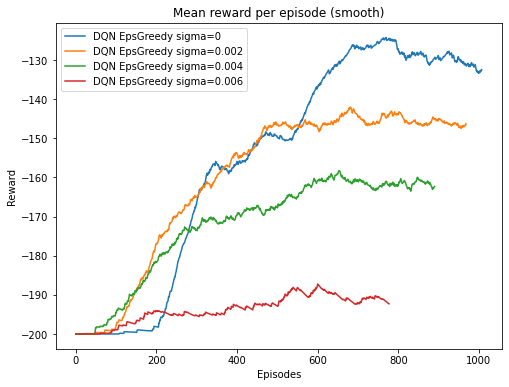

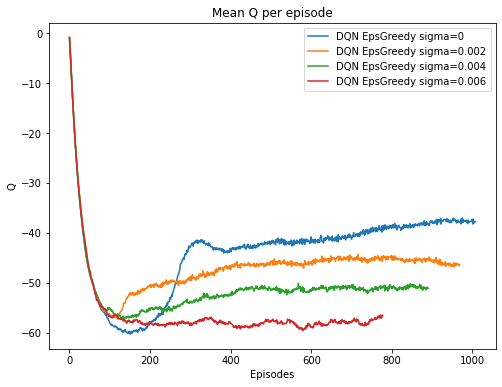

In [13]:
plot_results(False, 'EpsGreedy', [0, 0.002, 0.004, 0.006])

### DDQN EpsGreedy 

In [14]:
run_experiment(True, 'EpsGreedy', EpsGreedyQPolicy(eps=0.1), EpsGreedyQPolicy(eps=0.05), 0)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 105s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.744 - mae: 20.809 - mean_q: -30.793

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 105s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 7.894 - mae: 38.085 - mean_q: -56.428

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 9.499 - mae: 42.125 - mean_q: -62.445

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -197.320 [-200.000, -158.000] - loss: 9.640 - mae: 43.219 - mean_q: -64.079

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 108s

Total time: 27.0 min


In [15]:
run_experiment(True, 'EpsGreedy', EpsGreedyQPolicy(eps=0.1), EpsGreedyQPolicy(eps=0.05), 0.002)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.702 - mae: 20.770 - mean_q: -30.695

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -1.0000
51 episodes - episode_reward: -194.784 [-200.000, -125.000] - loss: 7.638 - mae: 37.903 - mean_q: -56.086

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: -1.0000
55 episodes - episode_reward: -180.036 [-200.000, -105.000] - loss: 7.755 - mae: 39.555 - mean_q: -58.306

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: -1.0000
59 episodes - episode_reward: -169.729 [-200.000, -102.000] - loss: 6.387 - mae: 38.300 - mean_q: -56.370

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 110s

In [16]:
run_experiment(True, 'EpsGreedy', EpsGreedyQPolicy(eps=0.1), EpsGreedyQPolicy(eps=0.05), 0.004)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 111s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -199.700 [-200.000, -185.000] - loss: 2.780 - mae: 21.132 - mean_q: -31.241

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: -1.0000
51 episodes - episode_reward: -193.392 [-200.000, -116.000] - loss: 7.627 - mae: 38.383 - mean_q: -56.783

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 111s 11ms/step - reward: -1.0000
53 episodes - episode_reward: -188.038 [-200.000, -111.000] - loss: 9.142 - mae: 41.096 - mean_q: -60.570

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 112s 11ms/step - reward: -1.0000
56 episodes - episode_reward: -179.821 [-200.000, -102.000] - loss: 8.598 - mae: 40.085 - mean_q: -58.816

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 113s

In [17]:
run_experiment(True, 'EpsGreedy', EpsGreedyQPolicy(eps=0.1), EpsGreedyQPolicy(eps=0.05), 0.006)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.918 - mae: 21.035 - mean_q: -31.072

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 112s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 8.071 - mae: 38.984 - mean_q: -57.690

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -199.040 [-200.000, -152.000] - loss: 9.658 - mae: 42.125 - mean_q: -62.319

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 115s 12ms/step - reward: -1.0000
50 episodes - episode_reward: -198.760 [-200.000, -165.000] - loss: 10.225 - mae: 42.925 - mean_q: -63.510

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 115

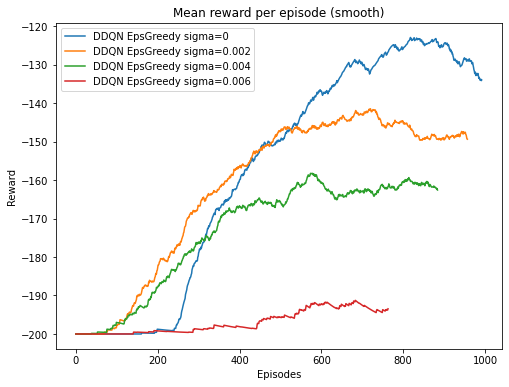

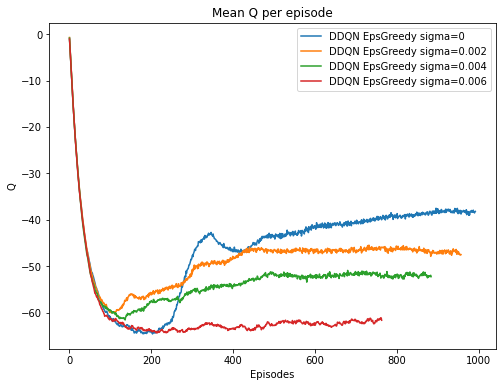

In [18]:
plot_results(True, 'EpsGreedy', [0, 0.002, 0.004, 0.006])

### DQN MaxBoltzmann 

In [19]:
run_experiment(False, 'MaxBoltzmann', MaxBoltzmannQPolicy(eps=0.1), MaxBoltzmannQPolicy(eps=0.05), 0)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.455 - mae: 19.856 - mean_q: -29.348

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 6.372 - mae: 35.821 - mean_q: -53.043

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -1.0000
54 episodes - episode_reward: -184.185 [-200.000, -129.000] - loss: 6.539 - mae: 38.261 - mean_q: -56.657

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 108s 11ms/step - reward: -1.0000
63 episodes - episode_reward: -158.825 [-200.000, -89.000] - loss: 4.592 - mae: 35.384 - mean_q: -52.247

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 109s 

Total time: 27.3 min


In [20]:
run_experiment(False, 'MaxBoltzmann', MaxBoltzmannQPolicy(eps=0.1), MaxBoltzmannQPolicy(eps=0.05), 0.002)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.455 - mae: 20.266 - mean_q: -29.994

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -196.860 [-200.000, -139.000] - loss: 7.019 - mae: 36.432 - mean_q: -53.930

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: -1.0000
53 episodes - episode_reward: -191.038 [-200.000, -124.000] - loss: 7.744 - mae: 39.220 - mean_q: -57.977

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 111s 11ms/step - reward: -1.0000
60 episodes - episode_reward: -164.933 [-200.000, -110.000] - loss: 6.354 - mae: 36.902 - mean_q: -54.260

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 114s

Total time: 28.1 min


In [21]:
run_experiment(False, 'MaxBoltzmann', MaxBoltzmannQPolicy(eps=0.1), MaxBoltzmannQPolicy(eps=0.05), 0.004)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.483 - mae: 20.229 - mean_q: -29.893

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -198.960 [-200.000, -148.000] - loss: 6.911 - mae: 35.756 - mean_q: -52.873

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 111s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -198.980 [-200.000, -149.000] - loss: 8.298 - mae: 38.815 - mean_q: -57.414

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 112s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 8.572 - mae: 40.402 - mean_q: -59.800

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 112s

Total time: 28.7 min


In [22]:
run_experiment(False, 'MaxBoltzmann', MaxBoltzmannQPolicy(eps=0.1), MaxBoltzmannQPolicy(eps=0.05), 0.006)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.596 - mae: 20.240 - mean_q: -29.877

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 112s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 7.322 - mae: 37.178 - mean_q: -54.989

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 112s 11ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 8.703 - mae: 40.535 - mean_q: -59.992

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 115s 12ms/step - reward: -1.0000
50 episodes - episode_reward: -198.660 [-200.000, -159.000] - loss: 9.009 - mae: 40.933 - mean_q: -60.576

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 119s

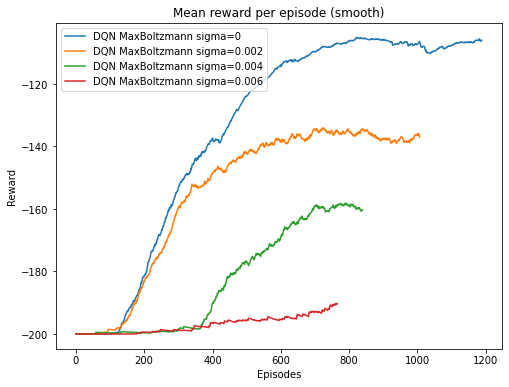

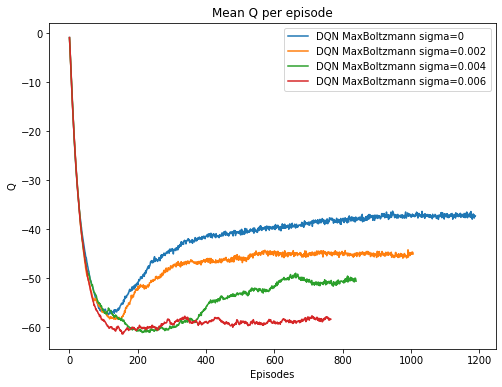

In [23]:
plot_results(False, 'MaxBoltzmann', [0, 0.002, 0.004, 0.006])

### DDQN MaxBoltzmann 

In [24]:
run_experiment(True, 'MaxBoltzmann', MaxBoltzmannQPolicy(eps=0.1), MaxBoltzmannQPolicy(eps=0.05), 0)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 132s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.788 - mae: 20.951 - mean_q: -30.968

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 132s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 8.147 - mae: 38.300 - mean_q: -56.678

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 131s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -199.820 [-200.000, -191.000] - loss: 9.439 - mae: 42.017 - mean_q: -62.228

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 131s 13ms/step - reward: -1.0000
51 episodes - episode_reward: -192.431 [-200.000, -142.000] - loss: 8.738 - mae: 42.357 - mean_q: -62.727

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 134s

Total time: 33.4 min


In [25]:
run_experiment(True, 'MaxBoltzmann', MaxBoltzmannQPolicy(eps=0.1), MaxBoltzmannQPolicy(eps=0.05), 0.002)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 136s 13ms/step - reward: -1.0000
51 episodes - episode_reward: -192.882 [-200.000, -109.000] - loss: 2.613 - mae: 20.514 - mean_q: -30.242

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 135s 13ms/step - reward: -1.0000
62 episodes - episode_reward: -161.403 [-200.000, -93.000] - loss: 4.972 - mae: 34.155 - mean_q: -50.054

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 138s 14ms/step - reward: -1.0000
65 episodes - episode_reward: -156.200 [-200.000, -87.000] - loss: 4.280 - mae: 34.842 - mean_q: -50.948

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 135s 14ms/step - reward: -1.0000
67 episodes - episode_reward: -148.134 [-200.000, -95.000] - loss: 3.726 - mae: 34.485 - mean_q: -50.463

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 137s 14

Total time: 34.4 min


In [26]:
run_experiment(True, 'MaxBoltzmann', MaxBoltzmannQPolicy(eps=0.1), MaxBoltzmannQPolicy(eps=0.05), 0.004)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: -1.0000
50 episodes - episode_reward: -199.920 [-200.000, -196.000] - loss: 2.726 - mae: 20.748 - mean_q: -30.662

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: -1.0000
50 episodes - episode_reward: -197.360 [-200.000, -120.000] - loss: 7.774 - mae: 38.863 - mean_q: -57.373

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: -1.0000
52 episodes - episode_reward: -191.135 [-200.000, -125.000] - loss: 8.856 - mae: 41.178 - mean_q: -60.573

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 143s 14ms/step - reward: -1.0000
58 episodes - episode_reward: -174.534 [-200.000, -112.000] - loss: 8.230 - mae: 41.049 - mean_q: -60.305

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 140s

Total time: 34.7 min


In [27]:
run_experiment(True, 'MaxBoltzmann', MaxBoltzmannQPolicy(eps=0.1), MaxBoltzmannQPolicy(eps=0.05), 0.006)

Training for 150000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 135s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.803 - mae: 20.855 - mean_q: -30.721

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 132s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -198.520 [-200.000, -159.000] - loss: 7.864 - mae: 38.229 - mean_q: -56.461

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 136s 14ms/step - reward: -1.0000
51 episodes - episode_reward: -196.784 [-200.000, -147.000] - loss: 9.547 - mae: 42.411 - mean_q: -62.642

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 135s 14ms/step - reward: -1.0000
51 episodes - episode_reward: -193.627 [-200.000, -138.000] - loss: 9.683 - mae: 42.396 - mean_q: -62.540

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 138s

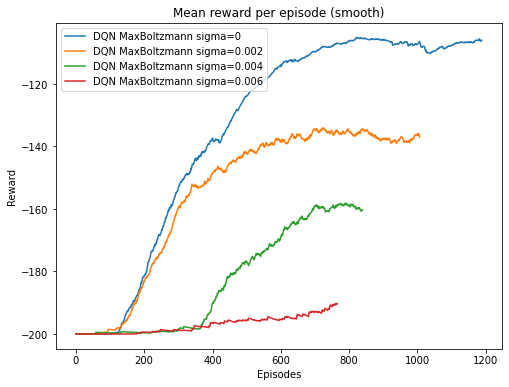

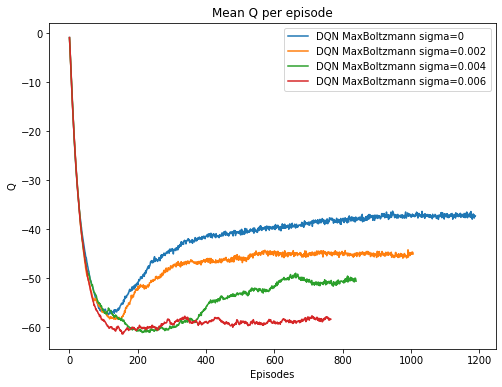

In [28]:
plot_results(False, 'MaxBoltzmann', [0, 0.002, 0.004, 0.006])

### Results per sigma

#### sigma=0

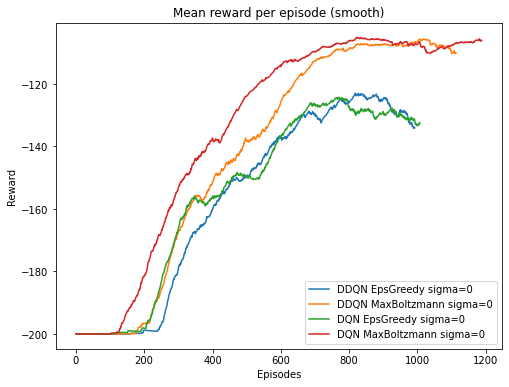

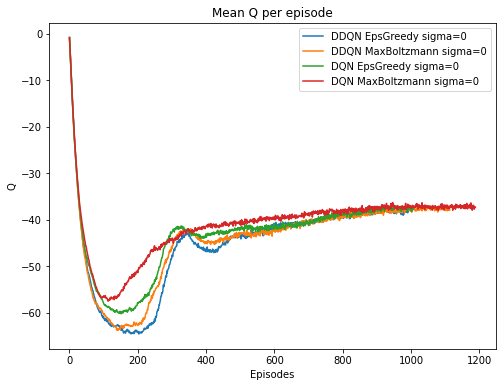

In [29]:
plot_results([True, False], ['EpsGreedy', 'MaxBoltzmann'], 0)

#### sigma=0.002

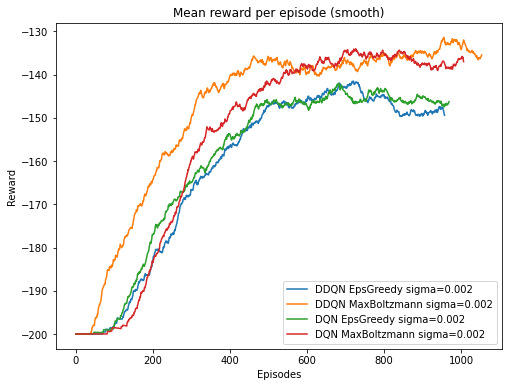

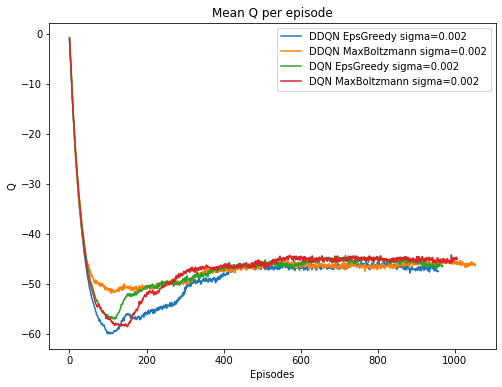

In [30]:
plot_results([True, False], ['EpsGreedy', 'MaxBoltzmann'], 0.002)

#### sigma=0.004

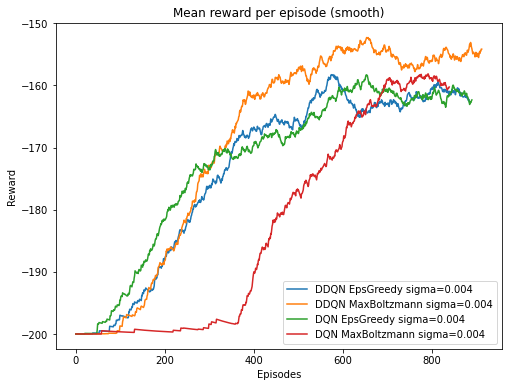

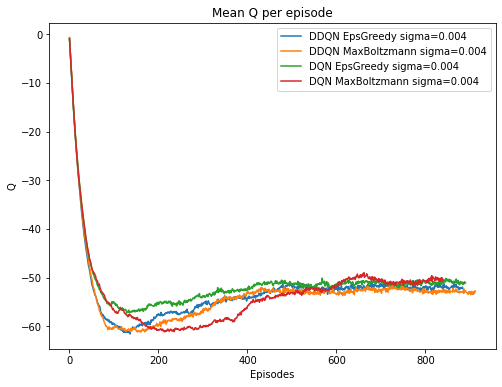

In [31]:
plot_results([True, False], ['EpsGreedy', 'MaxBoltzmann'], 0.004)

#### sigma=0.006

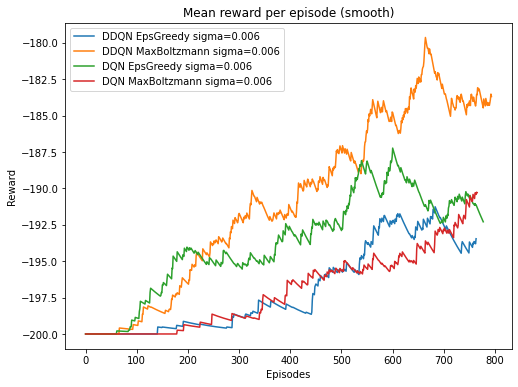

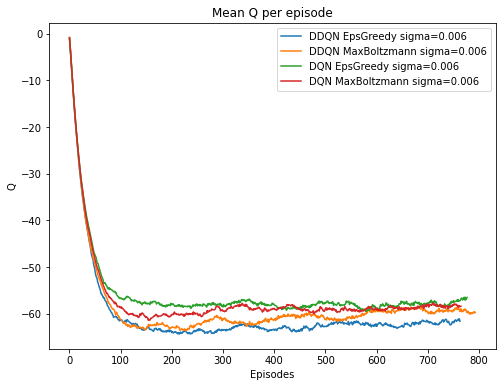

In [32]:
plot_results([True, False], ['EpsGreedy', 'MaxBoltzmann'], 0.006)

## References

1. Environment: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

2. Agent: https://github.com/wau/keras-rl2/blob/master/rl/agents/dqn.py

3. Policies: https://github.com/wau/keras-rl2/blob/master/rl/policy.py

4. Video recorder: https://medium.com/analytics-vidhya/rendering-openai-gym-environments-in-google-colab-9df4e7d6f99f

5. Example: https://bi3mer.github.io/blog/post_18/index.html